# Fairness calibration file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import load_data

workspace_path = '/Users/john/Projects/SOTAEvaluationNoduleDetection'

699 13189
699 24768
699 16804


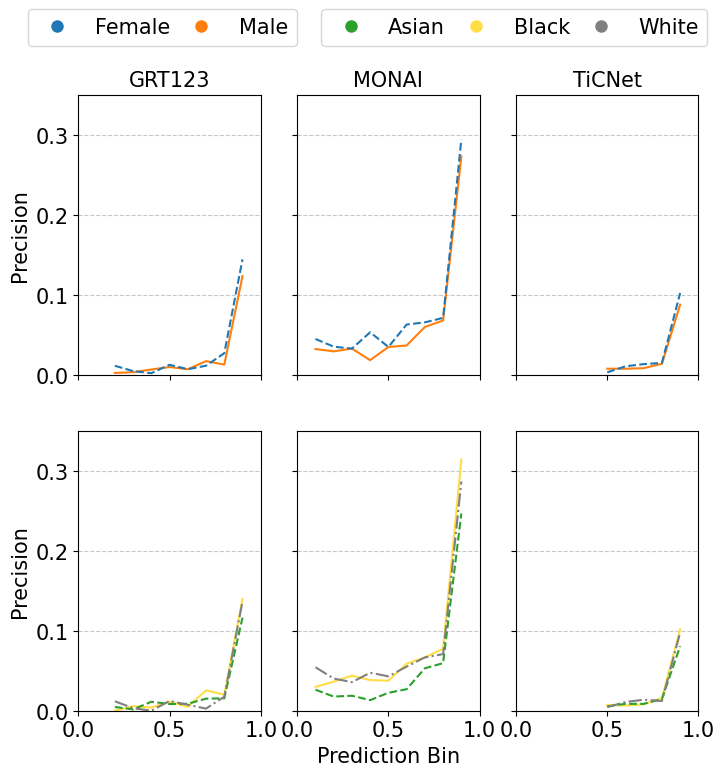

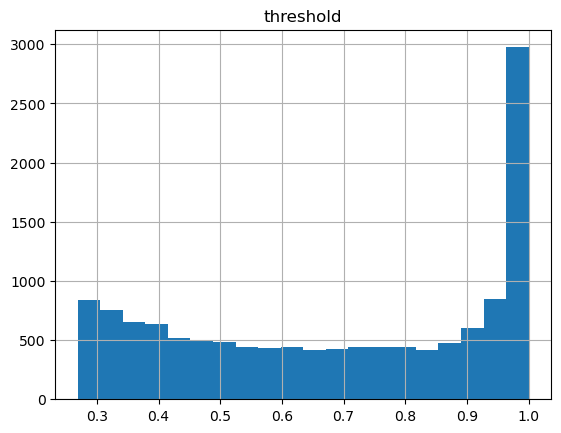

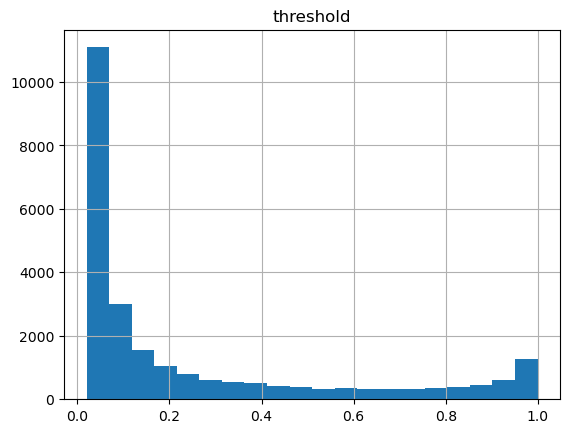

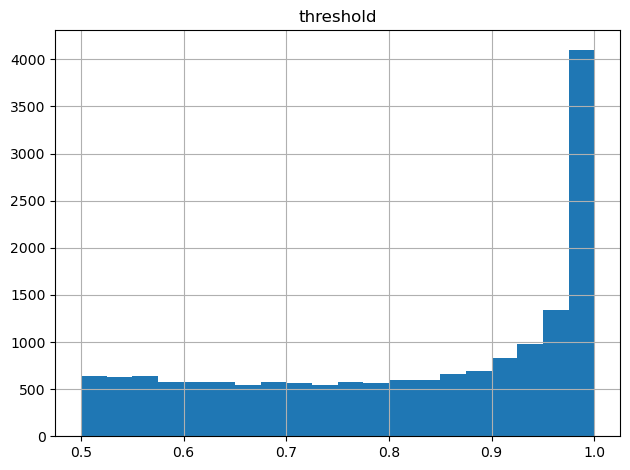

In [5]:


from matplotlib.lines import Line2D


def plot_claibration(dataset, model, flavour, annotations):
    # Define the number of bins
    confidence_bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # Create bins for the threshold values
    annotations['bin'] = pd.cut(annotations['threshold'], bins=confidence_bins, labels=confidence_bins[:-1])

    # Calculate accuracy for each bin

    bin_accuracy = annotations.groupby('bin')['nodule_detected'].count() / annotations.shape[0]
    display(bin_accuracy)


    # Calculate Expected Calibration Error (ECE)
    ece = np.sum(np.abs(bin_accuracy - confidence_bins[:-1]) * annotations['nodule_detected'].value_counts(normalize=True).sort_index())

    # Plot the accuracy
    plt.figure(figsize=(10, 6))
    bin_accuracy.plot(kind='bar')
    plt.xlabel('Prediction Bin')
    plt.ylabel('Accuracy')
    plt.title(f'Calibration Plot - {dataset} - {model} - {flavour}\nECE: {ece:.4f}')
    plt.ylim(0, 1)
    plt.xlim(-0.5, len(bin_accuracy) - 0.5)
    plt.show()    


dataset = "summit"
model = "grt123"
flavour = "test_balanced"

ece_dict = {}
# Plot the accuracy
fig, ax = plt.subplots(2, 3, figsize=(8, 8), sharex=True, sharey=True)

for ix, model in enumerate(['grt123', 'detection', 'ticnet']):
    annotations, results, scan_metadata, annotations_excluded = load_data(workspace_path, model, dataset, flavour, False)

    print(annotations.shape[0], results.shape[0])

    results = pd.merge(results, scan_metadata, left_on='name', right_on='Name', how='left')    

    results.hist('threshold', bins=20)

    annotations.reset_index(drop=True, inplace=True)
    results.reset_index(drop=True, inplace=True)

    def is_matched(scan_result, scan_annotation):
        annotation_centroid = np.array([scan_annotation['row'], scan_annotation['col'], scan_annotation['index']])
        result_centroid = np.array([scan_result['row'], scan_result['col'], scan_result['index']])
        distance = np.linalg.norm(annotation_centroid - result_centroid)
        return distance <= (scan_annotation['diameter'] / 2)

    nodule_detected = {rdx : 0 for rdx in results.index}
    for scan in scan_metadata['Name'].values:

        subset_annotations = annotations[annotations['name'] == scan]
        subset_results = results[results['name'] == scan]

        for rdx, scan_result in subset_results.iterrows():
            for adx, scan_annotation in subset_annotations.iterrows():
                if is_matched(scan_result, scan_annotation):
                    nodule_detected[rdx] = 1

    # Rescale thresholds into 0-1 range
    results['threshold_rescaled'] = (results['threshold'] - results['threshold'].min()) / (results['threshold'].max() - results['threshold'].min())

    results['nodule_detected'] = pd.Series(nodule_detected)
    results['bin'] = pd.cut(
        results['threshold'], 
        bins=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
        labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    )

    precision_per_bin = pd.crosstab(
        results['bin'],
        results['nodule_detected'],
        normalize='index'
    ).rename(columns={0: 'precision_negative', 1: 'precision_positive'})

    # display(precision_per_bin)

    # Calculate statistics for each bin
    bin_stats = results.groupby('bin')['threshold'].agg(['min', 'max', 'mean', 'count']).rename(columns={'count': 'total_cases'})
    nod_stats = results.groupby('bin')['nodule_detected'].sum().rename('total_nodules')

    bin_stats = bin_stats.join(nod_stats)

    # Display the table
    # display(bin_stats)

    model_mappings = {
        'grt123': 'GRT123',
        'detection': 'MONAI',
        'ticnet': 'TiCNet'
    }

    abs_per_bin = pd.crosstab(
        results['bin'],
        results['nodule_detected'],
        # normalize='index'
    ).rename(columns={0: 'precision_negative', 1: 'precision_positive'})


    # Calculate Expected Calibration Error (ECE)
    ece = np.sum(np.abs(precision_per_bin['precision_positive'] - precision_per_bin.index.astype(float)) * results['bin'].value_counts(normalize=True).sort_index())
    ece_dict[f'{dataset}_{model}_all'] = ece

    # Define color-blind-friendly palette
    colors = {
        'FEMALE': '#1f77b4',  # Blue
        'MALE': '#ff7f0e',    # Orange
        'Female': '#1f77b4',  # Blue
        'Male': '#ff7f0e',    # Orange
        'Asian or Asian British': '#2ca02c',   # Green
        'Black': '#ffdd44',   # Yellow
        'White': 'grey',   # Grey
        'Other': '#d62728'    # Red
    }

    # Define color-blind-friendly palette
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-']

    # ax[0, ix].plot(
    #     precision_per_bin.index, 
    #     precision_per_bin['precision_positive'], 
    #     label='Model Calibration', 
    #     color='black', 
    #     linestyle='--'
    # )


    for idx, category in enumerate(results['gender'].unique()):
        subset_results = results[results.gender == category]
        
        precision_per_bin = pd.crosstab(
            subset_results['bin'],
            subset_results['nodule_detected'],
            normalize='index'
        ).rename(columns={0: 'precision_negative', 1: 'precision_positive'})

        ece = np.sum(np.abs(precision_per_bin['precision_positive'] - precision_per_bin.index.astype(float)) * results['bin'].value_counts(normalize=True).sort_index())
        ece_dict[f'{dataset}_{model}_{category}'] = ece

        ax[0, ix].plot(
            precision_per_bin.index, 
            precision_per_bin['precision_positive'], 
            label=f"{category.replace('FEMALE','Female').replace('MALE','Male')}", 
            color=colors.get(category, '#000000'),  # Use color from dictionary or default to black
            linestyle=line_styles[idx % len(line_styles)]
        )

    # ax[1, ix].plot(
    #     precision_per_bin.index, 
    #     precision_per_bin['precision_positive'], 
    #     label='Model Calibration', 
    #     color='black', 
    #     linestyle='--'
    # )
    for idx, category in enumerate(results['ethnic_group'].unique()):
        subset_results = results[results.ethnic_group == category]
        
        precision_per_bin = pd.crosstab(
            subset_results['bin'],
            subset_results['nodule_detected'],
            normalize='index'
        ).rename(columns={0: 'precision_negative', 1: 'precision_positive'})

        ece = np.sum(np.abs(precision_per_bin['precision_positive'] - precision_per_bin.index.astype(float)) * results['bin'].value_counts(normalize=True).sort_index())
        ece_dict[f'{dataset}_{model}_{category}'] = ece

        ax[1, ix].plot(
            precision_per_bin.index, 
            precision_per_bin['precision_positive'], 
            label=f'{category.replace("Asian or Asian British", "Asian")}', 
            color=colors.get(category, '#000000'),  # Use color from dictionary or default to black
            linestyle=line_styles[idx % len(line_styles)]
        )


    # ax[ix].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.5)  # Add 1:1 dashed line with light opacity
    # ax[1, ix].set_title(f'{model_mappings[model]}')
    ax[0, ix].set_ylim(0, 0.35)
    ax[0, ix].set_xlim(0, 1)
    ax[0, ix].grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    ax[1, ix].grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

    ax[0, ix].tick_params(axis='both', which='major', labelsize=15)
    ax[1, ix].tick_params(axis='both', which='major', labelsize=15)


legend_elements_sex = [
    # Line2D([0], [0], marker='o', color='w', label='Total', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor=colors['Female'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor=colors['Male'], markersize=10),
]

legend_elements_ethnic = [
    # Line2D([0], [0], marker='o', color='w', label='Total', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Asian', markerfacecolor=colors['Asian or Asian British'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Black', markerfacecolor=colors['Black'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='White', markerfacecolor=colors['White'], markersize=10)
]

fig.legend(
    handles=legend_elements_sex,
    loc='upper center',
    ncol=len(legend_elements_sex),
    bbox_to_anchor=(0.23, 1),
    fontsize=15,
    frameon=True,
    columnspacing=0.5  # Reduce space between legend labels
)

fig.legend(
    handles=legend_elements_ethnic,
    loc='upper center',
    ncol=len(legend_elements_ethnic),
    bbox_to_anchor=(0.67, 1),
    fontsize=15,
    frameon=True,
    columnspacing=0.5  # Reduce space between legend labels
)

# Update font sizes for labels, ticks, and legends
ax[0,0].set_title(f'GRT123', fontsize=15)
ax[0,1].set_title(f'MONAI', fontsize=15)
ax[0,2].set_title(f'TiCNet', fontsize=15)
ax[1, 1].set_xlabel('Prediction Bin', fontsize=15)
ax[0, 0].set_ylabel('Precision', fontsize=15)
ax[1, 0].set_ylabel('Precision', fontsize=15)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(f'/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/FairnessInNoduleDetectionAlgorithms/results/extension/images/summit_test_balanced_calibration.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [3]:
df = pd.DataFrame.from_dict(ece_dict, orient='index', columns=['ECE']).reset_index().rename(columns={'index': 'descriptor'})
df[['dataset', 'model', 'category']] = df.descriptor.str.split('_', expand=True)

df.to_clipboard()


In [4]:

import pandas as pd

with open('/Users/john/Projects/NCRAS/audit-mpi (1) 2/Participant.csv', 'rb') as file:
    content = file.read()

offending_chars = []
for i, byte in enumerate(content):
    try:
        byte.to_bytes(1, 'big').decode('utf-8')
    except UnicodeDecodeError:
        row = content[:i].count(b'\n') + 1
        line_pos = i - content[:i].rfind(b'\n')
        offending_chars.append((byte, row, line_pos))

for char, row, line_pos in offending_chars:
    print(f"Offending character: {char} at row {row}, position {line_pos}")

Offending character: 160 at row 107007, position 352
Offending character: 160 at row 170368, position 333
Offending character: 160 at row 175566, position 348
